In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import pickle
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from portraits.plotting import axis_matras, axis_net, line_palette_annotation_plot


/home/jovyan/projects/TKI_IO_perdictor_Stupichev/MFP/TME_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TKI_palette = {
    'Low': '#6E672C',
    'Medium': '#979234',
    'High':'#ACA715'
}
recist = {'R': '#66dd66', 'NR': '#f26755'}

def classify_score(score):
    if score <= 0.55:
        return 'Low'
    elif 0.55 < score <= 0.8:
        return 'Medium'
    else:
        return 'High'

# Loading and Inspecting a Pretrained Gene Signature Model

In [3]:
# Import utility for reading gene sets (not used in this cell but may be used later)
from portraits.utils import read_gene_sets

# Load a saved model dictionary from a .pickle file
# The file contains various components of a trained model (e.g., classifier, metadata, parameters)
with open('Data/ccrcc_tki_0.1.pickle', "rb") as f:
    model_dict = pickle.load(f)

# Display the keys in the loaded dictionary to understand what components are available
# Common keys might include: 'model', 'features', 'params', etc.
model_dict.keys()


/home/jovyan/projects/TKI_IO_perdictor_Stupichev/MFP/TME_env/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.1.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


dict_keys(['model', 'features', 'data', 'gene_signature'])

In [4]:
# Extract the trained modelfrom the loaded dictionary
model = model_dict['model']

# Extract the list of features used for training the model
features = model_dict['features']

# Extract the gene signature (likely in GMT format or similar) used for feature generation
gmt = model_dict['gene_signature']

# Display the model coefficients (weights assigned to each feature by the model)
# These reflect the importance and direction (positive/negative) of each feature in prediction
model_dict['model'].coef_


array([[ 0.39398058, -0.26055865, -0.6713639 ]])

In [5]:
# Extract signature expression data for training and validation sets
# These are likely gene set activity scores or pathway-level features
train_expression = model_dict['data']['train_signature']
validation_expression = model_dict['data']['validation_signature']

# Extract sample-level annotations (e.g. clinical data, labels) for training and validation sets
train_annotation = model_dict['data']['train_annotation']
validation_annotation = model_dict['data']['validation_annotation']

## Prepare Training Features and Labels

In [6]:
# Align feature matrix (X) with available annotations (y) by index
# This ensures that both features and labels refer to the same samples
X = train_expression.loc[train_annotation.index]
y = train_annotation

In [7]:
X.head()

,Angiogenesis,Macrophages,Proliferation_rate
Sample 10,1.236958,1.404008,0.873214
Sample 11,0.674490,0.264348,1.081181
Sample 13,-0.798730,-0.847935,-0.236326
Sample 14,-1.204849,-2.620739,1.089760
Sample 15,-0.808993,-0.053119,-0.468193


In [8]:
train_annotation.value_counts()

R     167
NR     73
Name: Recist, dtype: int64

## Model coefficients

In [9]:
model.coef_

array([[ 0.39398058, -0.26055865, -0.6713639 ]])

# Ability Prediction Model

In [10]:
# Initialize and train a logistic regression model using training features (X) and labels (y)
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [11]:
# View the coefficients of the trained logistic regression model
model.coef_

array([[ 0.39398058, -0.26055865, -0.6713639 ]])

In [12]:
# Extract the expression data for validation samples,
# aligning it with the corresponding annotation index
X_new = validation_expression.loc[validation_annotation.index]
X_new

,Angiogenesis,Macrophages,Proliferation_rate
Imm150_262873171124023,1.604719,-0.467038,-1.343252
Imm150_69015818905746,0.739392,1.217798,2.059253
Imm150_121121567855264,-0.655489,0.165246,0.505075
Imm150_71331376983724,0.177488,0.943912,-1.215135
Imm150_276496020777021,-2.391940,1.597465,1.887787
...,...,...,...
ID_002603,0.583597,1.132249,3.295559
ID_000178,0.526681,1.114101,0.012757
ID_000100,-0.451886,-0.683950,0.388210
ID_000081,-1.331007,-0.805620,1.002988


In [13]:
# Training set
y_train_pred = model.predict(X)               # Binary class prediction (0 or 1)
y_train_proba = model.predict_proba(X)        # Probability estimates for each class

# Validation set
y_test_pred = model.predict(X_new)            # Binary class prediction on validation data
y_test_proba = model.predict_proba(X_new)     # Probability estimates on validation data

In [14]:
# Create a DataFrame to store model predictions for training samples
Samples_pred = pd.DataFrame(y_train_pred, index=X.index, columns=['Predictions'])
Samples_pred.index.name = None

# Assign a categorical score label (Low / Medium / High) based on predicted probability for the positive class
Samples_pred['TKI_Score_Category'] = np.array([classify_score(score[1]) for score in y_train_proba])

In [15]:
# Convert the 'TKI_Score_Category' column to an ordered categorical type
Samples_pred['TKI_Score_Category'] = pd.Categorical(
    Samples_pred['TKI_Score_Category'],
    categories=['Low', 'Medium', 'High'],
    ordered=True
)

# Sort the predictions by score category
Samples_pred_sorted = Samples_pred.sort_values(by='TKI_Score_Category')

# Reorder the expression data to match the sorted prediction DataFrame
Samples_sorted = X.loc[Samples_pred_sorted.index]

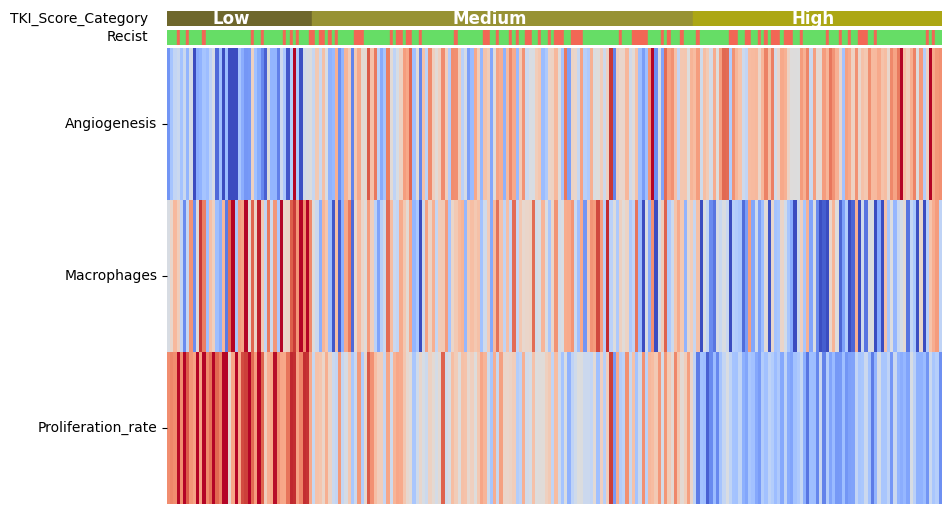

In [16]:
# Set the colormap to use for the heatmap
default_cmap = matplotlib.cm.coolwarm

# Create a custom layout with axis_matras — this sets up vertical space allocation for plots
af = axis_matras([.2, .2, 6], x_len=10)

# First row: predicted TKI score category (Low / Medium / High)
annotation_ax = next(af)
line_palette_annotation_plot(
    Samples_pred_sorted['TKI_Score_Category'], 
    palette=TKI_palette, 
    ax=annotation_ax
)

# Manually label each score category on the axis
categories = ['Low', 'Medium', 'High']
x_pos = [20, 100, 200]  # Adjusted X positions for label placement
y_pos = [0.5, 0.5, 0.5]  # Fixed Y position (centered on the line)

for i, category in enumerate(categories):
    annotation_ax.text(x_pos[i], y_pos[i], category, ha='center', va='center',
                       color='white', fontsize=12, fontweight='bold')

# Second row: ground-truth RECIST responses
annotation_ax = next(af)
line_palette_annotation_plot(
    y, 
    palette=recist, 
    ax=annotation_ax
)

# Third row: gene signature heatmap (features in rows, samples in columns)
heatmap_ax = next(af)
sns.heatmap(Samples_sorted.T, cmap=default_cmap,
            cbar=False, vmin=-2, vmax=2, 
            xticklabels=False, ax=heatmap_ax)

# Make Y-axis labels (feature names) horizontal and readable
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), rotation=0, ha='right', fontsize=10)

# Adjust spacing between rows of the plot
plt.subplots_adjust(hspace=0.02)
